# Introduction

I downloaded a dataset of apple quality on kaggle : https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality

The goal is to predict if an apple is good or bad

In [1]:
import pyopencl as cl

platforms = cl.get_platforms()
for platform in platforms:
    print("Platform:", platform.name)
    devices = platform.get_devices()
    for device in devices:
        print("  Device:", device.name)
        print("    Type:", cl.device_type.to_string(device.type))
        print("    Vendor:", device.vendor)
        print("    Max Compute Units:", device.max_compute_units)
        print("    Global Memory Size:", device.global_mem_size // (1024*1024), "MB")
        print("    Max Clock Frequency:", device.max_clock_frequency, "MHz")
        print("    Max Work Group Size:", device.max_work_group_size)
        print("    Max Work Item Sizes:", device.max_work_item_sizes)
        print("    OpenCL Version:", device.opencl_c_version)
        print("    Driver Version:", device.driver_version)
        print()

Platform: AMD Accelerated Parallel Processing
  Device: gfx90c
    Type: ALL | GPU
    Vendor: Advanced Micro Devices, Inc.
    Max Compute Units: 7
    Global Memory Size: 6222 MB
    Max Clock Frequency: 1600 MHz
    Max Work Group Size: 256
    Max Work Item Sizes: [1024, 1024, 1024]
    OpenCL Version: OpenCL C 2.0 
    Driver Version: 3584.0 (PAL,HSAIL)



# Import libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

C:\Users\anton\AppData\Local\Temp\ipykernel_16512\1991857245.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
apple = pd.read_csv(os.path.join("apple_quality", "apple_quality.csv"))

In [4]:
apple.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [5]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


Here I can see that the acidity is also an object whereas it's composed of numerical values

In [6]:
apple["Acidity"].value_counts()

Acidity
-0.491590483                         1
0.416518576                          1
1.223084441                          1
2.190636353                          1
5.125138503                          1
                                    ..
-0.08899782                          1
-0.3815496                           1
4.67363368                           1
-0.76858734                          1
Created_by_Nidula_Elgiriyewithana    1
Name: count, Length: 4001, dtype: int64

In [7]:
apple.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


array([[<Axes: title={'center': 'A_id'}>,
        <Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'Sweetness'}>,
        <Axes: title={'center': 'Crunchiness'}>,
        <Axes: title={'center': 'Juiciness'}>],
       [<Axes: title={'center': 'Ripeness'}>, <Axes: >, <Axes: >]],
      dtype=object)

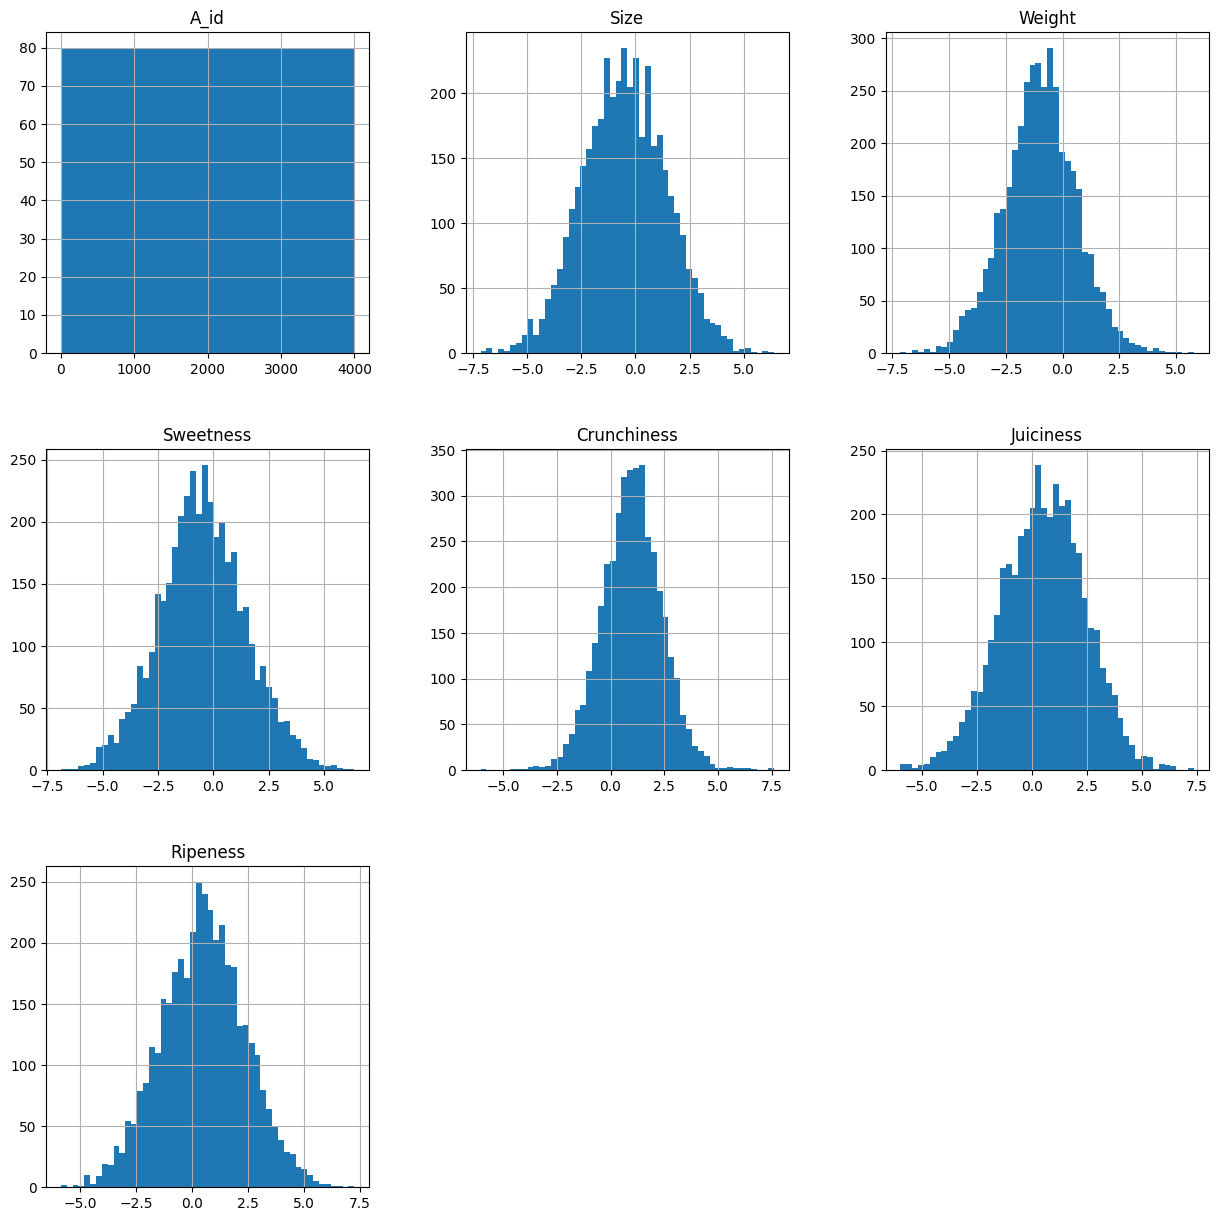

In [8]:
apple.hist(bins = 50, figsize=(15,15))

In [9]:
missing_values = apple.isnull().sum()
print(missing_values)

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64


In [10]:
# I delete the only value that contains null
apple_cleaned = apple.dropna()

# So now only one line has been deleted
print("Number of line :", len(apple_cleaned))

Number of line : 4000


In [11]:
apple_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 312.5+ KB


In [12]:
apple_cleaned["Acidity"]

0       -0.491590483
1       -0.722809367
2        2.621636473
3        0.790723217
4        0.501984036
            ...     
3995     0.137784369
3996     1.854235285
3997    -1.334611391
3998    -2.229719806
3999     1.599796456
Name: Acidity, Length: 4000, dtype: object

In [13]:
# I convert the acidity
apple_cleaned['Acidity'] = pd.to_numeric(apple['Acidity'], errors='coerce')

C:\Users\anton\AppData\Local\Temp\ipykernel_16512\3936742188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_cleaned['Acidity'] = pd.to_numeric(apple['Acidity'], errors='coerce')


In [14]:
apple_cleaned.info() #Now acidities are float64

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 312.5+ KB


In [15]:
apple_cleaned.isnull().sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

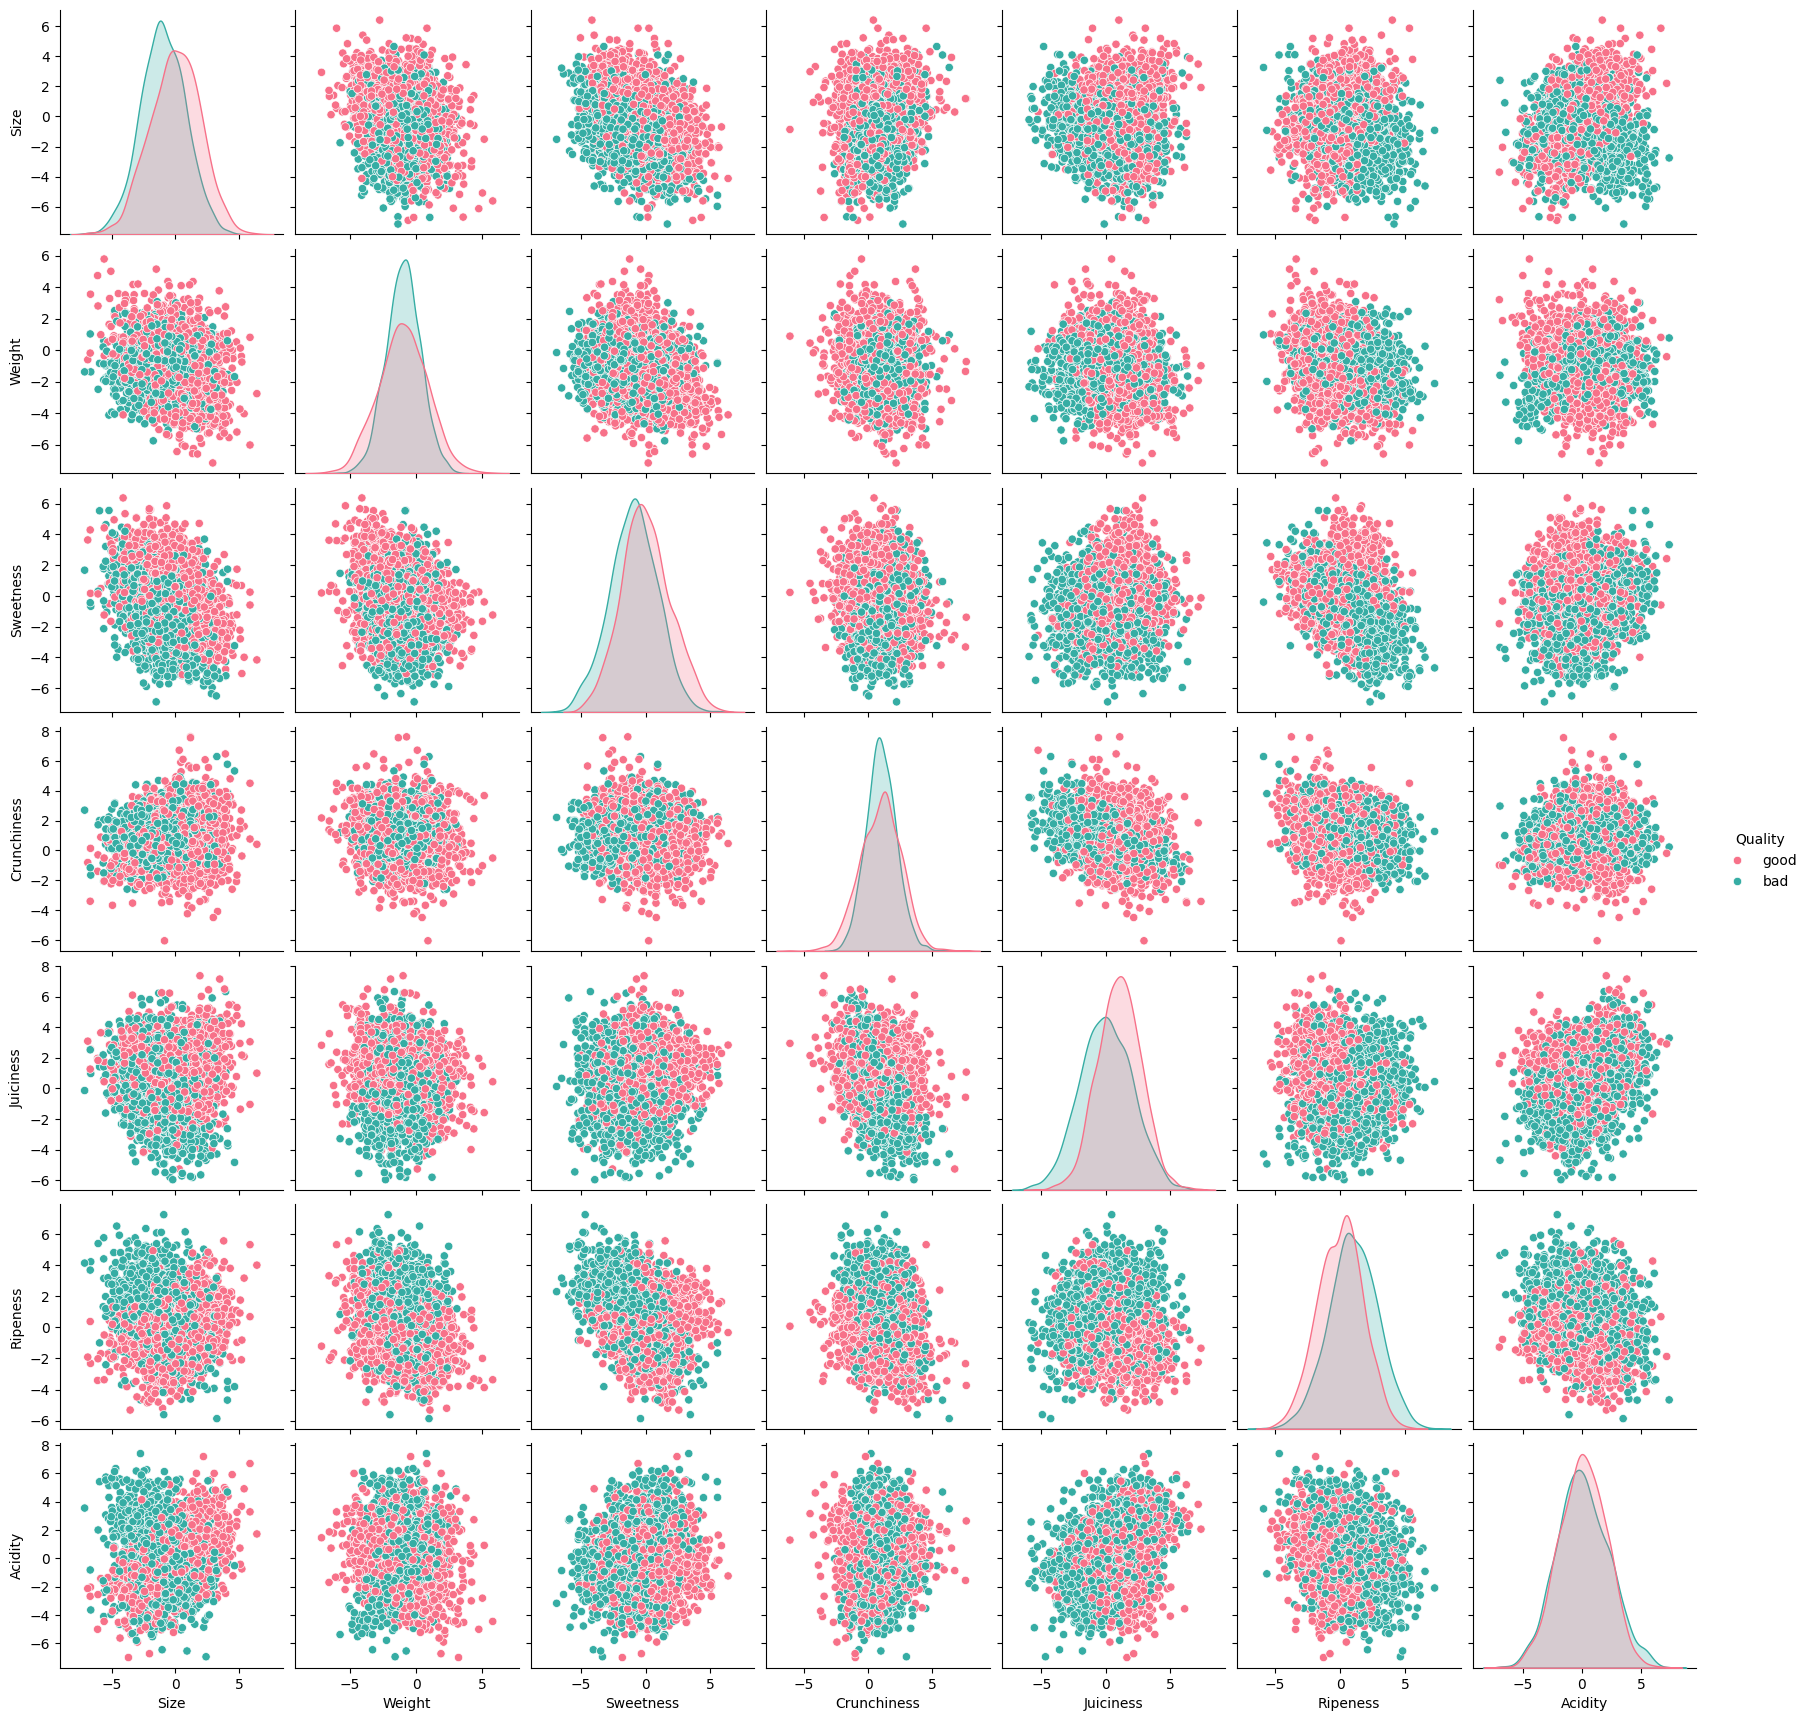

In [16]:
import seaborn as sns

apple_cleaned = apple_cleaned.drop(columns=['A_id'])
sns.pairplot(apple_cleaned, hue='Quality', palette='husl')
plt.show()

In [17]:
apple_cleaned["Quality"]

0       good
1       good
2        bad
3       good
4       good
        ... 
3995     bad
3996    good
3997     bad
3998    good
3999    good
Name: Quality, Length: 4000, dtype: object

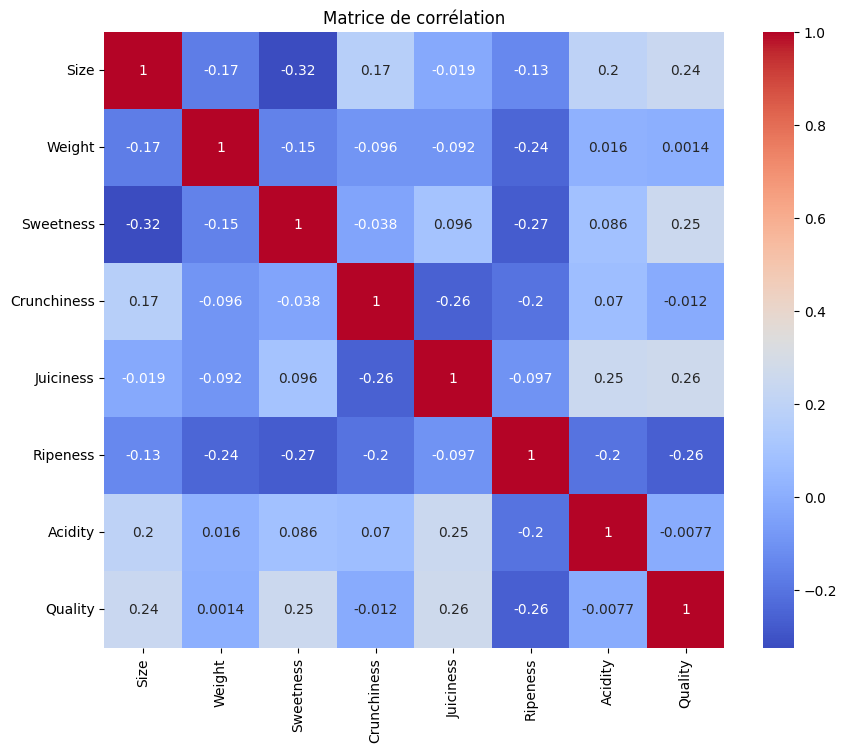

In [18]:
#Mapping
quality_mapping = {'good': 1, 'bad': 0}

apple_cleaned['Quality'] = apple_cleaned['Quality'].map(quality_mapping)

correlation_matrix = apple_cleaned.corr()

#Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

# Test and train set

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(apple_cleaned, apple_cleaned["Quality"]):
    train_set = apple_cleaned.loc[train_index]
    test_set = apple_cleaned.loc[test_index]

In [20]:
len(train_set)

3200

In [21]:
len(test_set)

800

In [22]:
test_set["Quality"].value_counts() / len(test_set)

Quality
1    0.50125
0    0.49875
Name: count, dtype: float64

In [23]:
train_set["Quality"].value_counts() / len(train_set)

Quality
1    0.500938
0    0.499063
Name: count, dtype: float64

In [24]:
apple_cleaned["Quality"].value_counts() / len(apple_cleaned)

Quality
1    0.501
0    0.499
Name: count, dtype: float64

The repartition is good

In [25]:
def income_cat_proportions(data):
    return data["Quality"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(apple_cleaned),
    "Stratified": income_cat_proportions(train_set),
    "Random": income_cat_proportions(train_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [26]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
Quality,,,,,
0,0.499,0.499063,0.499063,0.012525,0.012525
1,0.501,0.500938,0.500938,-0.012475,-0.012475


# Let's discover our datas !!

In [27]:
apple_train = train_set.copy()

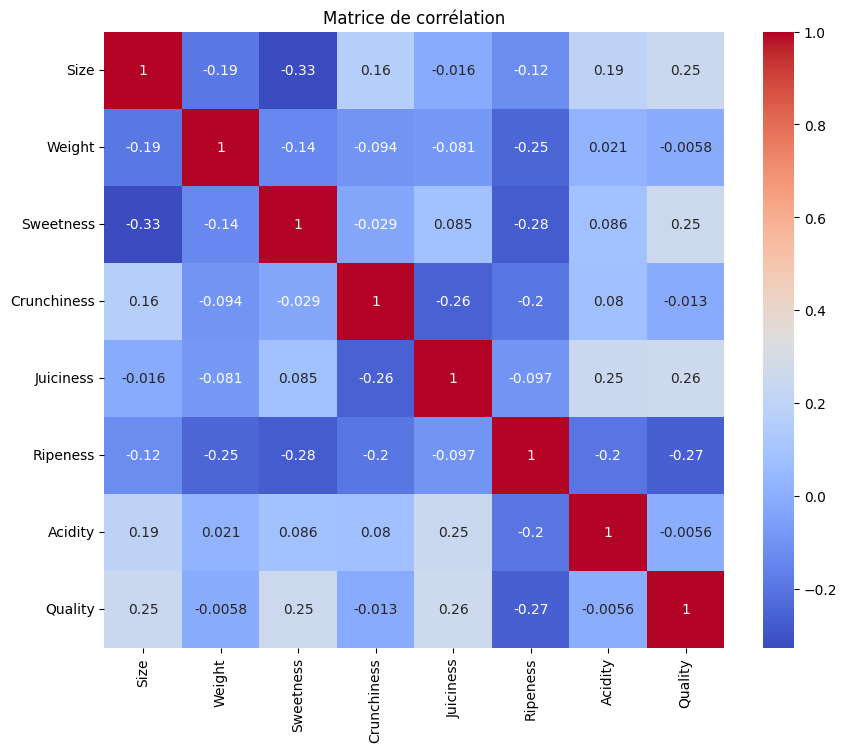

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = apple_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

In [29]:
correlation_with_quality = correlation_matrix["Quality"].sort_values(ascending=False)
print(correlation_with_quality)

Quality        1.000000
Juiciness      0.261178
Sweetness      0.252653
Size           0.247533
Acidity       -0.005602
Weight        -0.005757
Crunchiness   -0.013162
Ripeness      -0.266937
Name: Quality, dtype: float64


So here we can see which features can help us to predict the quality of an apple. We could have guessed it but the juice, the sweetness, the size and the ripeness are correlated. In my mind, acidity and crunchiness would have played a bigger role.

In [ ]:
import matplotlib.pyplot as plt

features = ['Juiciness', 'Sweetness', 'Size', 'Acidity', 'Weight', 'Crunchiness', 'Ripeness']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 4, i)
    plt.scatter(apple_train[feature], apple_train['Quality'], alpha=0.5)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Quality')
plt.tight_layout()
plt.show()

In [ ]:
corr_matrix = apple_train.corr()
corr_matrix["Quality"].sort_values(ascending=False)

# Prepare the data for machine learning

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

apple = apple_train.drop("Quality", axis=1) #Drop the label
apple_label = apple_train["Quality"].copy() #Save the label

No need to clean the data as it's from kaggle, I've already removed one apple that had missing attributes

In [31]:
sample_incomplete_rows = apple[apple.isnull().any(axis=1)].head()
sample_incomplete_rows

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity


Cool !

In [32]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 337 to 2040
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         3200 non-null   float64
 1   Weight       3200 non-null   float64
 2   Sweetness    3200 non-null   float64
 3   Crunchiness  3200 non-null   float64
 4   Juiciness    3200 non-null   float64
 5   Ripeness     3200 non-null   float64
 6   Acidity      3200 non-null   float64
dtypes: float64(7)
memory usage: 200.0 KB


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

numeric_features = apple.select_dtypes(include=['float64']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

apple_prepared = preprocessor.fit_transform(apple)

In [34]:
apple_prepared #So now apple_prepared is matrices !

array([[0.45287933, 0.71853058, 0.63332744, ..., 0.55328668, 0.05074904,
        0.66691376],
       [0.45883602, 0.4406054 , 0.59481611, ..., 0.3291736 , 0.46743578,
        0.40074663],
       [0.40782907, 0.71512384, 0.47897107, ..., 0.58500763, 0.3444819 ,
        0.67281939],
       ...,
       [0.53552699, 0.5367685 , 0.34404612, ..., 0.16997668, 0.53218183,
        0.29338052],
       [0.78598533, 0.08914326, 0.37779426, ..., 0.59058256, 0.59341422,
        0.65462016],
       [0.48917882, 0.33724823, 0.38949603, ..., 0.60655744, 0.29660554,
        0.47855096]])

In [35]:
import pandas as pd

apple_prepared_df = pd.DataFrame(apple_prepared, columns=numeric_features)

In [36]:
apple_prepared_df

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,0.452879,0.718531,0.633327,0.669105,0.553287,0.050749,0.666914
1,0.458836,0.440605,0.594816,0.399434,0.329174,0.467436,0.400747
2,0.407829,0.715124,0.478971,0.507271,0.585008,0.344482,0.672819
3,0.662587,0.418775,0.331902,0.408573,0.552086,0.494475,0.525210
4,0.374357,0.509683,0.415629,0.668005,0.273372,0.299034,0.406700
...,...,...,...,...,...,...,...
3195,0.496602,0.502224,0.501531,0.542076,0.541598,0.541045,0.372150
3196,0.457844,0.518644,0.537647,0.435105,0.444073,0.559051,0.337679
3197,0.535527,0.536769,0.344046,0.383913,0.169977,0.532182,0.293381
3198,0.785985,0.089143,0.377794,0.390096,0.590583,0.593414,0.654620


In [37]:
apple_prepared_df.shape #And the shape is what it should so let's train

(3200, 7)

Good !

# Try of Random forest

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import joblib

from sklearn.ensemble import RandomForestClassifier

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


param_grid = {
    'classifier__n_estimators': [10, 20, 50],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(apple_prepared_df, apple_label)


print("Best parameters")
print(grid_search.best_params_)


best_model = grid_search.best_estimator_
best_model.fit(apple_prepared_df, apple_label)

Best parameters
{'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 20}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness',
       'Acidity'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, min_samples_leaf=2,
                                        min_samples_split=5,
                                        n_estimators=20))])

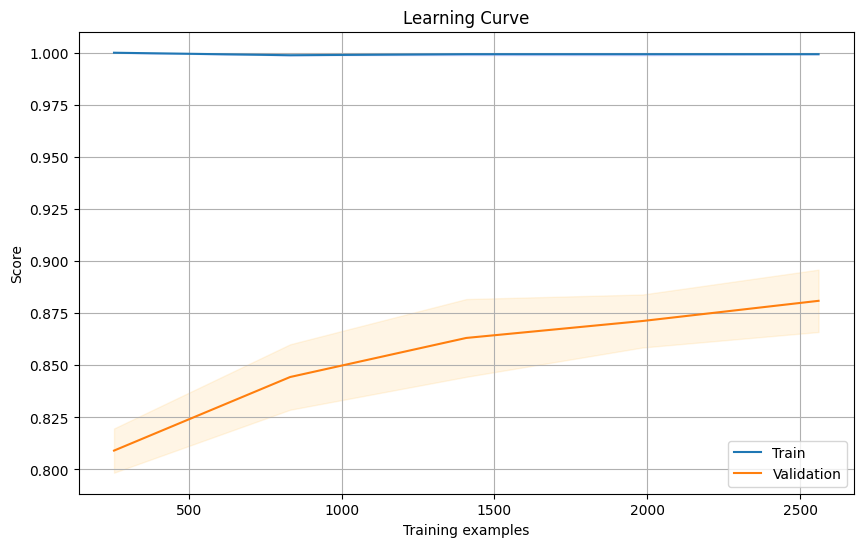

In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_model, apple_prepared_df, apple_label, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, valid_scores_mean, label='Validation')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


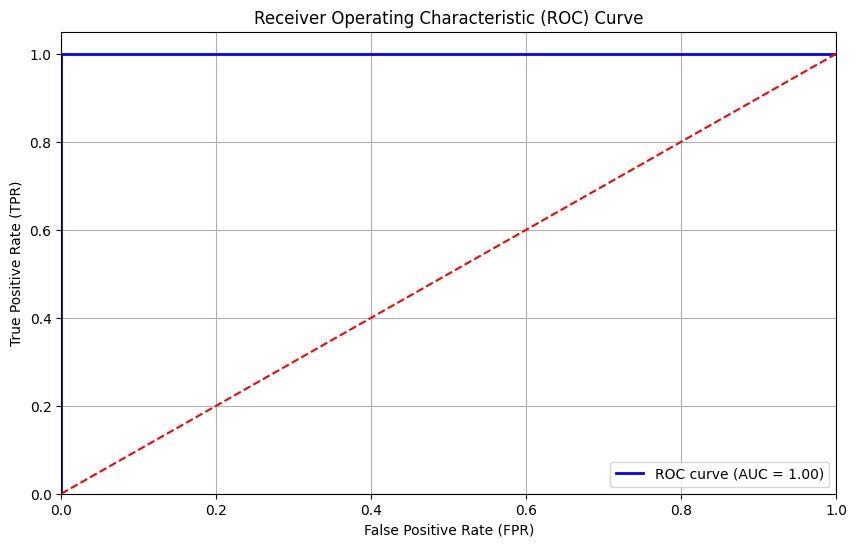

In [40]:
from sklearn.metrics import roc_curve, auc

probs = best_model.predict_proba(apple_prepared_df)
probs = probs[:, 1]

# Calculer le taux de vrais positifs (TPR) et le taux de faux positifs (FPR)
fpr, tpr, thresholds = roc_curve(apple_label, probs)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [41]:
apple_test = test_set.drop("Quality", axis=1) #Drop the label
apple_label_test = test_set["Quality"].copy() #Save the label
apple_test = preprocessor.fit_transform(apple_test)
apple_test.shape
apple_test_df = pd.DataFrame(apple_test, columns=numeric_features)
#Evalutation

In [42]:
#Evalutation
y_pred = best_model.predict(apple_test_df)
print("\nReport :")
print(classification_report(apple_label_test, y_pred))


Report :
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       399
           1       0.73      0.94      0.82       401

    accuracy                           0.80       800
   macro avg       0.83      0.80      0.79       800
weighted avg       0.83      0.80      0.79       800



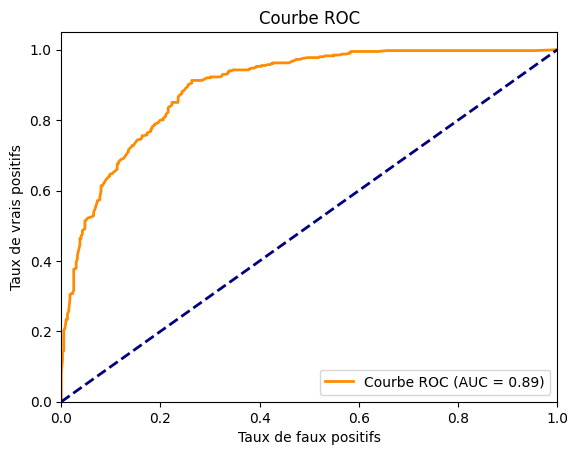

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_model.predict_proba(apple_test_df)[:, 1]

fpr, tpr, thresholds = roc_curve(apple_label_test, y_prob)

roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [44]:
roc_auc

0.8942368389802438

In [47]:
#Save model
joblib.dump(best_model, 'random_forest_apple.pkl')

['random_forest_apple.pkl']

In [46]:
logistic_model = joblib.load('random_forest_apple.pkl')

# Voting Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# Construction des différents classifieurs
random_forest = RandomForestClassifier()
svm = SVC()
knn = KNeighborsClassifier()

# Définition des hyperparamètres à rechercher pour chaque classifieur
param_grid = {
    'random_forest__n_estimators': [1, 3],
    'random_forest__max_depth': [None, 1, 3],
    'svm__C': [0.01, 0.1],
    'svm__gamma': [0.1, 1, 'scale'],
    'knn__n_neighbors': [1, 3]
}

# Création du VotingClassifier
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', random_forest),
    ('knn', knn),
    ('svm', SVC())
])

# Création du pipeline complet avec prétraitement
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
    # ('kmeans', KMeans(random_state=42)),
])

# Recherche des meilleurs hyperparamètres pour le VotingClassifier
grid_search = GridSearchCV(voting_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(apple_prepared_df, apple_label)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés par la recherche par grille:")
print(grid_search.best_params_)


In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(apple_prepared_df, apple_label)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_model, apple_prepared_df, apple_label, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, valid_scores_mean, label='Validation')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import joblib

In [ ]:
apple_test = test_set.drop("Quality", axis=1) #Drop the label
apple_label_test = test_set["Quality"].copy() #Save the label
apple_test = preprocessor.fit_transform(apple_test)
apple_test.shape
apple_test_df = pd.DataFrame(apple_test, columns=numeric_features)
#Evalutation
y_pred = best_model.predict(apple_test_df)
print("\nReport :")
print(classification_report(apple_label_test, y_pred))